Launch this notebook:

https://colab.research.google.com/github/agile-geoscience/striplog/blob/develop/tutorial/Markov_chains.ipynb

-----

## Markov chains for `striplog`

Initially based on [Alfredo Molina on Medium](https://medium.com/@__amol__/markov-chains-with-python-1109663f3678), then incorporating quasi-independence model from Powers & Easterling, https://doi.org/10.1306/212F808F-2B24-11D7-8648000102C1865D. 

You need `striplog` version 0.8.2 for this notebook to work.

In [1]:
import striplog

striplog.__version__

'0.8.3'

## Parse states

All of the Markov chain code I could find wanted a transition matrix as input. But I wanted to be able to provide a sequence, then get the transitions from it. So we need to be able to parse a sequence of states &mdash; tokens representing the items in the sequence we are modeling. 

For example, we need the unique elements and 'sequence of sequences' from:

- A list of states, eg `[10, 20, 10, 20, 20, 10]`
- A string of states, eg `'ABBDDDDDCCCC'`
- A list of lists of states, eg `[[1,2,2,3], [2,4,2]]`  (NB, not same length)
- A list of strings of states, eg `['aaabb', 'aabbccc']` (NB, not same length)
- A list of state names, eg `['sst', 'mud', 'sst']` (requires optional argument)
- A list of lists of state names, eg `[['SS', 'M', 'SS'], ['M', 'M', 'LS']]`

The uniques should look like:

- `[10, 20]`
- `['A', 'B', 'C', 'D']`
- `[1, 2, 3, 4]`
- `['a', 'b', 'c']`
- `['mud', sst']`
- `['LS', 'M', 'SS']`

And the sequences of sequences:

- `[10, 20, 10, 20, 20, 10]`
- `['A', 'B', 'B', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C']`
- `[[1,2,2,3], [2,4,2]]`
- `[['a', 'a', 'a', 'b', 'b'], ['a', 'a', 'b', 'b', 'c', 'c', 'c']]`
- `[['sst', 'mud', 'sst']]`
- `[['SS', 'M', 'SS'], ['M', 'M', 'LS']]`

For some reason, this turned out to be a bit fiddly. But for now, things work.

In [2]:
from striplog.markov import Markov_chain

----

## Powers & Easterling data

Let's use one of the examples in Powers & Easterling &mdash; they use this transition matrix from Gingerich, PD (1969). Markov analysis of cyclic alluvial sediments. _Journal of Sedimentary Petrology_, 39, p. 330-332. https://doi.org/10.1306/74D71C4E-2B21-11D7-8648000102C1865D

In [3]:
data = [[ 0, 37,  3,  2],
        [21,  0, 41, 14],
        [20, 25,  0,  0],
        [ 1, 14,  1,  0]]

m = Markov_chain(data, states=['A', 'B', 'C', 'D'])

m

Markov_chain(179 transitions, states=['A', 'B', 'C', 'D'], step=1)

### Testing for independence

`scipy.stats` has a function, `chi2_contingency()` for computing chi-squared, the p-value, the degrees of freedom, and the expected transitions under the assumption of independence:

In [4]:
import scipy.stats

chi, p, dof, expected = scipy.stats.chi2_contingency(m.observed_counts)

However, there are problems with this:

1. The chi-squared test is not strictly valid when we have fewer than 5 counts for some cells. Instead, it is better to use Fisher's exact test.
1. We wish not to include self-transitions.
1. We prefer a condition of quasi-independence, as discussed by Powers & Easterling and by Goodman (1968) before them. See https://agilescientific.com/blog/2019/4/19/the-order-of-stratigraphic-sequences.

Fisher's exact test is notoriously difficult to compute for tables larger than 2 x 2, but in theory we can use the [`FisherExact`](https://github.com/maclandrol/FisherExact) module by Marc-Rolland Noutahi (see [his blog post](https://mrnoutahi.com/2016/01/03/Fisher-exac-test-for-mxn-table/)) to check Fisher's exact statistic.

In the meantime, we have Powers & Easterling and the assumption of quasi-independence.

First, let's look at the expected transition frequencies:

In [5]:
import numpy as np

np.set_printoptions(precision=8)

In [6]:
m.expected_counts

array([[ 0.        , 31.27069125,  8.17143874,  2.55787001],
       [31.28238248,  0.        , 34.05692583, 10.66069169],
       [ 8.17137105, 34.04391563,  0.        ,  2.78471333],
       [ 2.5579797 , 10.65716447,  2.78485582,  0.        ]])

The $\chi^2$ statistic shows the value for the observed ordering, along with the critical value at (by default) the 95% confidence level. If the first number is higher than the second number (ideally much higher), then we can reject the hypothesis that the ordering is quasi-independent. That is, we have shown that the ordering is non-random.

In [7]:
m.chi_squared()

Chi2(chi2=35.73687369691601, crit=11.070497693516351, perc=0.9999989278539752)

### Which transitions are interesting?

The normalized difference shows which transitions are 'interesting'. These numbers can be interpreted as standard deviations away from the model of quasi-independence. That is, transitions with large positive numbers represent passages that occur more often than might be expected. Any numbers greater than 2 are likely to be important.

In [8]:
m.normalized_difference

array([[ 0.        ,  1.02455077, -1.80909811, -0.3488139 ],
       [-1.83841622,  0.        ,  1.18973184,  1.02273667],
       [ 4.13796624, -1.55001803,  0.        , -1.66874603],
       [-0.97412177,  1.02398637, -1.0695517 ,  0.        ]])

We can visualize this as an image:

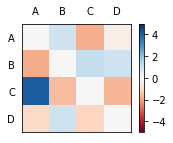

In [9]:
m.plot_norm_diff()

We can also interpret this matrix as a graph. The transitions from A to C are particularly strong in this one. Transitions from C to A happen less often than we'd expect. Those from B to D and D to B, less so.

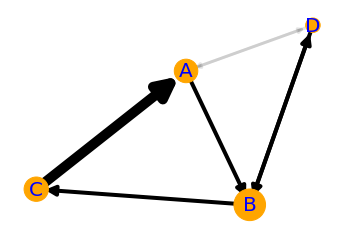

In [10]:
%matplotlib inline
m.plot_graph()

We can look at an undirected version of the graph too. It downplays non-reciprocal relationships. I'm not sure this is useful...

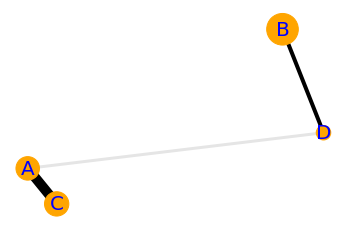

In [11]:
%matplotlib inline
m.plot_graph(directed=False)

We can generate a random succession of beds with the same transition statistics:

In [12]:
''.join(m.generate_states(n=20))

'CBABABDBDBCABDCABDBC'

----

## Data from Matt's thesis

These are the transitions from some measured sections in my PhD thesis. They start at the bottom, so in Log 7, we start with lithofacies 1 (offshore mudstone) and pass upwards into lithofacies 3, then back into 1, then 3, and so on.

We can instantiate a `Markov_chain` object from a sequence using its `from_sequence()` method. This expects either a sequence of 'states' (numbers or letters or strings representing rock types) or a sequence of sequences of states.

In [13]:
data = {
    'log7': [1, 3, 1, 3, 5, 1, 2, 1, 3, 1, 5, 6, 1, 2, 1, 2, 1, 2, 1, 3, 5, 6, 5, 1],
    'log9': [1, 3, 1, 5, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 1, 5, 6, 5, 6, 1, 2, 1, 5, 6, 1],
    'log11': [1, 3, 1, 2, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 3, 5, 1, 9, 5, 5, 5, 5, 6, 1],
    'log12': [1, 5, 3, 1, 2, 1, 2, 1, 2, 1, 4, 5, 6, 1, 2, 1, 4, 5, 1, 5, 5, 5, 1, 2, 1, 8, 9, 10, 9, 5, 1],
    'log13': [1, 6, 1, 3, 1, 3, 5, 3, 6, 1, 6, 5, 3, 1, 5, 1, 2, 1, 4, 3, 5, 3, 4, 3, 5, 1, 5, 9, 11, 9, 1],
    'log14': [1, 3, 1, 5, 8, 5, 6, 1, 3, 4, 5, 3, 1, 3, 5, 1, 7, 7, 7, 1, 7, 1, 3, 8, 5, 5, 1, 5, 9, 9, 11, 9, 1],
    'log15': [1, 8, 1, 3, 5, 1, 2, 3, 6, 3, 6, 5, 2, 1, 2, 1, 8, 5, 1, 5, 9, 9, 11, 1],
    'log16': [1, 8, 1, 5, 1, 5, 5, 6, 1, 3, 5, 3, 5, 5, 5, 8, 5, 1, 9, 9, 3, 1],
    'log17': [1, 3, 8, 1, 8, 5, 1, 8, 9, 5, 10, 5, 8, 9, 10, 8, 5, 1, 8, 9, 1],
    'log18': [1, 8, 2, 1, 2, 1, 10, 8, 9, 5, 5, 1, 2, 1, 2, 9, 5, 9, 5, 8, 5, 9, 1]
}

logs = list(data.values())

m = Markov_chain.from_sequence(logs, states=range(1,12))
m.observed_counts

array([[ 0., 21., 17.,  3., 15.,  2.,  2.,  8.,  2.,  1.,  0.],
       [21.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [12.,  0.,  0.,  2., 12.,  3.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [19.,  1.,  9.,  0.,  0.,  9.,  0.,  4.,  5.,  1.,  0.],
       [ 9.,  0.,  1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  1.,  0.,  0.,  7.,  0.,  0.,  0.,  5.,  0.,  0.],
       [ 4.,  0.,  1.,  0.,  6.,  0.,  0.,  0.,  0.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.]])

Let's check out the normalized difference matrix:

In [14]:
m.expected_counts

array([[0.00000000e+00, 9.73433553e+00, 1.36181600e+01, 1.97204020e+00,
        2.32864499e+01, 5.70888383e+00, 7.80656027e-01, 6.57617560e+00,
        6.57617560e+00, 1.57211591e+00, 1.17500740e+00],
       [9.73386186e+00, 0.00000000e+00, 2.94880326e+00, 4.27015000e-01,
        5.04232288e+00, 1.23617106e+00, 1.69039066e-01, 1.42396977e+00,
        1.42396977e+00, 3.40417541e-01, 2.54429796e-01],
       [1.36174683e+01, 2.94879697e+00, 0.00000000e+00, 5.97385015e-01,
        7.05410378e+00, 1.72937735e+00, 2.36482102e-01, 1.99210379e+00,
        1.99210379e+00, 4.76236989e-01, 3.55941940e-01],
       [1.97194977e+00, 4.27016198e-01, 5.97387964e-01, 0.00000000e+00,
        1.02150694e+00, 2.50431666e-01, 3.42450460e-02, 2.88477163e-01,
        2.88477163e-01, 6.89640249e-02, 5.15440619e-02],
       [2.32850125e+01, 5.04225698e+00, 7.05402664e+00, 1.02149073e+00,
        0.00000000e+00, 2.95712627e+00, 4.04369490e-01, 3.40637193e+00,
        3.40637193e+00, 8.14335236e-01, 6.08638285e-

In [15]:
np.set_printoptions(suppress=True, precision=1, linewidth=120)
m.normalized_difference

array([[ 0. ,  3.6,  0.9,  0.7, -1.7, -1.6,  1.4,  0.6, -1.8, -0.5, -1.1],
       [ 3.6,  0. , -1.1, -0.7, -2.2, -1.1, -0.4, -1.2, -0.4, -0.6, -0.5],
       [-0.4, -1.7,  0. ,  1.8,  1.9,  1. , -0.5,  0. , -1.4, -0.7, -0.6],
       [-1.4, -0.7,  1.8,  0. ,  2. , -0.5, -0.2, -0.5, -0.5, -0.3, -0.2],
       [-0.9, -1.8,  0.7, -1. ,  0. ,  3.5, -0.6,  0.3,  0.9,  0.2, -0.8],
       [ 1.4, -1.1, -0.6, -0.5,  0.6,  0. , -0.3, -0.9, -0.9, -0.4, -0.4],
       [ 1.4, -0.4, -0.5, -0.2, -0.6, -0.3,  0. , -0.3, -0.3, -0.2, -0.1],
       [-1.4, -0.4, -1.4, -0.5,  1.9, -0.9, -0.3,  0. ,  4.1, -0.5, -0.4],
       [-1. , -1.2, -0.7, -0.5,  1.4, -0.9, -0.3, -1. ,  0. ,  3.7,  6.8],
       [-1.3, -0.6, -0.7, -0.3,  0.2, -0.4, -0.2,  3.7,  1.6,  0. , -0.2],
       [-0.2, -0.5, -0.6, -0.2, -0.8, -0.4, -0.1, -0.4,  4.4, -0.2,  0. ]])

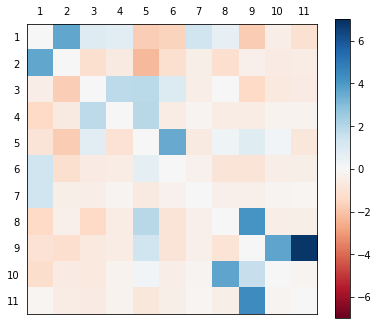

In [16]:
m.plot_norm_diff()

And the graph version. **Note you can re-run this cell to rearrange the graph.**

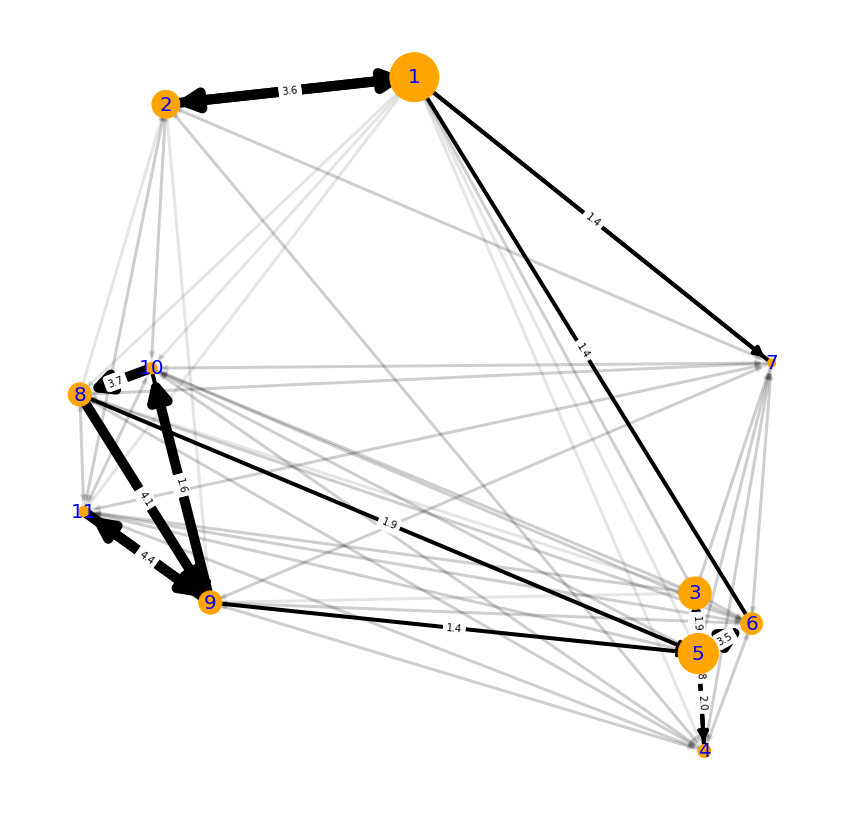

In [17]:
m.plot_graph(figsize=(15,15), max_size=2400, edge_labels=True)

----

## Step = 2

So far we've just been looking at direct this-to-that transitions, i.e. only considering each previous transition. What if we use the previous-but-one?

In [18]:
m = Markov_chain.from_sequence(logs, states=range(1,12), step=2)

Now we have a 3D 'matrix' of transition probabilities.

In [19]:
m.normalized_difference.shape

(11, 11, 11)

This is hard to inspect! Let's just get the indices of the highest values.

If we add one to the indices, we'll have a handy list of facies number transitions, since these are just 1 to 11. So we can interpret these as transitions with anomalously high probability. 

<img src="Normal_distribution.png" />

In [20]:
idx = np.where(m.normalized_difference > 1.28)  # 1.28 is 80% confidence
locs = np.array(list(zip(*idx)))

for score, loc in zip(m.normalized_difference[idx], locs):
    print(f"{' > '.join(map(str,loc+1)):>12}   {score:.3f}")

   1 > 2 > 1   3.819
   1 > 8 > 9   1.366
  5 > 9 > 11   1.356
  8 > 9 > 10   3.122
  9 > 9 > 11   3.241
  9 > 11 > 9   3.665


These represent, respectively (it's stochastic so some of these might be missing):

    1  >  2  >  1
    1  >  8  >  9
    5  >  9  >  11
    8  >  9  >  10
    9  >  9  >  11
    9  >  10 >  9
    9  >  11 >  9

In [21]:
m.chi_squared()

Chi2(chi2=2224.4608937464127, crit=112.02198574980785, perc=1.0)

Unfortunately, it's a bit harder to draw this as a graph. Technically, it's a [**hypergraph**](https://en.wikipedia.org/wiki/Hypergraph).

In [22]:
# This should error for now.
m.plot_graph(figsize=(15,15), max_size=2400, edge_labels=True)

MarkovError: You can only graph one-step chains.

----

## Fake data

Let's also make a Markov model from a long string of transitions.

In [23]:
data = "sssmmmlllmlmlsslsllsmmllllmssssllllssmmlllllssssssmmmmsmllllssslmslmsmmmslsllll"""

In [24]:
m = Markov_chain.from_sequence(data, include_self=True)
m

Markov_chain(78 transitions, states=['l', 'm', 's'], step=1)

In [25]:
m.observed_counts

array([[19.,  5.,  7.],
       [ 6.,  9.,  5.],
       [ 7.,  6., 14.]])

In [26]:
m._state_probs

array([0.4, 0.3, 0.3])

In [27]:
m.observed_freqs

array([[0.6, 0.2, 0.2],
       [0.3, 0.4, 0.2],
       [0.3, 0.2, 0.5]])

In [28]:
m.expected_freqs

array([[0.5, 0.2, 0.3],
       [0.5, 0.2, 0.3],
       [0.5, 0.2, 0.3]])

In [29]:
m.states

array(['l', 'm', 's'], dtype='<U1')

Conditional probabilities given a 'current' state:

In [30]:
m._conditional_probs('l')

array([0.6, 0.2, 0.2])

A random sequence generated from the Markov chain model:

In [31]:
m.generate_states(12)

['s', 'l', 's', 'l', 'l', 's', 'm', 's', 'l', 's', 's', 's']

## 'Idealized' successions: shoreface

Based on [this conversation](https://twitter.com/clasticdetritus/status/1120713140893777920). 

Let's make a shoreface-type of thing:

- mud
- cross-bedded medium sand
- fine sand
- silt
- mud

We'll do it very naively, with multiple complete sequences.

In [32]:
data = "msfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfcmsfc"

In [33]:
m = Markov_chain.from_sequence(data)
m

Markov_chain(71 transitions, states=['c', 'f', 'm', 's'], step=1)

In [34]:
m.normalized_difference

array([[ 0. , -2.5,  4.6, -2.5],
       [ 5.1,  0. , -2.5, -2.5],
       [-2.3, -2.4,  0. ,  5.1],
       [-2.4,  4.8, -2.5,  0. ]])

In [35]:
m.expected_counts

array([[0. , 6. , 5.9, 6. ],
       [5.8, 0. , 6. , 6.2],
       [5.4, 5.8, 0. , 5.8],
       [5.8, 6.2, 6. , 0. ]])

In [36]:
m.expected_freqs

array([[0. , 0.3, 0.3, 0.3],
       [0.3, 0. , 0.3, 0.3],
       [0.3, 0.3, 0. , 0.3],
       [0.3, 0.3, 0.3, 0. ]])

In [39]:
m.chi_squared()

Chi2(chi2=142.33420063416094, crit=11.070497693516351, perc=1.0)

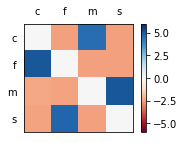

In [40]:
m.plot_norm_diff()

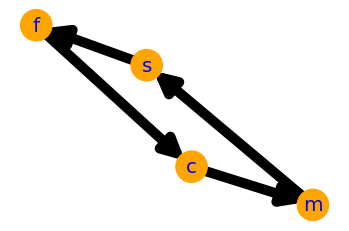

In [41]:
m.plot_graph()

## Idealized succession: more realistic

Often, we don't get a full succession. What if we randomly cut it short, but always return to 'm'?

In [42]:
succession = 'msfc'

data = ''
for _ in range(100):
    stop = np.random.randint(len(succession))
    data += succession[:stop+1]
    
data

'mmsfmsmmsmsmsfmsfcmsmsfcmsfmsmsfmsfmsmsfcmmsmsfmsmsmsmsfmmmsmmmsfmsfcmsfmsmsfmsfcmsfcmmsfmsfcmsmsmsmmsmmmsmsfcmsfmsfmsmsfmmmsmsfcmsfmsfcmsfcmsmsfmsfcmsfcmsfcmsmmsmmmmsfcmsfcmsmmsfcmmsmsmsmmsfmsfmmsfmsfmsmsmmsmmsfcmsfcmsmsfmsmsmmsmsfmsms'

In [43]:
m = Markov_chain.from_sequence(data, include_self=False)
m

Markov_chain(211 transitions, states=['c', 'f', 'm', 's'], step=1)

In [44]:
m.normalized_difference

array([[ 0. , -1.8,  3.9, -2.8],
       [ 9. ,  0. ,  0.7, -4.3],
       [-2.8, -4.3,  0. ,  4. ],
       [-2.8,  5. , -2.1,  0. ]])

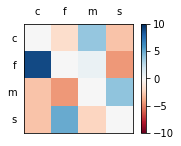

In [45]:
m.plot_norm_diff()

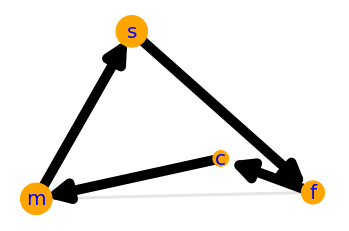

In [46]:
m.plot_graph()

So the 'correct' graph emerges.

## More realistic still

What if some of the transgressions are incomplete? (I.e. random start and end.)

In [47]:
np.set_printoptions(precision=3)

In [48]:
data = ''
l = len(succession)
for _ in range(100):
    start = np.random.randint(l)
    length = min(l-start, np.random.randint(l))
    data += succession[start:length+1]

data

'msffmsfmsssfcsfcsfcfffsfcsmsfmsfcmmmsfmsmsfmsfcfsfcfmsmsfmsfsfsfmssfmsfmmsffmsmsfsmfmsfmsmsmsmsmsmmsfmfmsfcsfmsfc'

In [49]:
m = Markov_chain.from_sequence(data, include_self=False)
m

Markov_chain(101 transitions, states=['c', 'f', 'm', 's'], step=1)

In [50]:
m.normalized_difference

array([[ 0.   ,  0.144, -0.92 ,  0.101],
       [ 4.153,  0.   ,  1.601, -2.875],
       [-1.457, -2.616,  0.   ,  3.052],
       [-1.845,  2.007, -1.251,  0.   ]])

In [51]:
m.chi_squared()

Chi2(chi2=56.2310540143378, crit=11.070497693516351, perc=0.9999999999271679)

In [52]:
print("Chi2(chi2=48.36996, crit=11.07050, perc=0.99999)")

Chi2(chi2=48.36996, crit=11.07050, perc=0.99999)


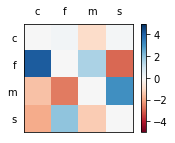

In [53]:
m.plot_norm_diff()

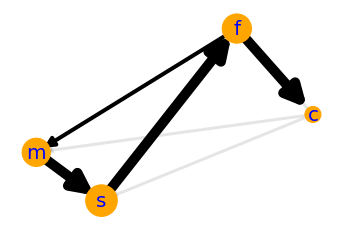

In [54]:
m.plot_graph()

## Example for Brian

Based on [this conversation](https://twitter.com/clasticdetritus/status/1120713140893777920). 

In [55]:
succession = ['sub', 'inter', 'supra']

In [56]:
data = 20 * succession

In [57]:
m = Markov_chain.from_sequence(data, strings_are_states=True, include_self=False)
m

Markov_chain(59 transitions, states=['inter', 'sub', 'supra'], step=1)

In [58]:
m.normalized_difference

array([[ 0.   , -3.19 ,  3.245],
       [ 3.246,  0.   , -3.029],
       [-3.189,  2.925,  0.   ]])

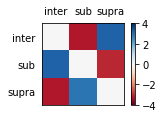

In [59]:
m.plot_norm_diff()

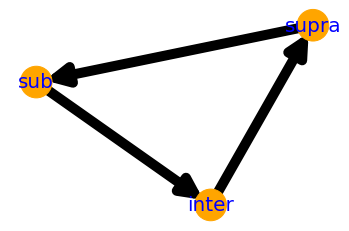

In [60]:
m.plot_graph()

In [61]:
data = []
l = len(succession)
for _ in range(40):
    start = np.random.randint(l)
    length = min(l-start, np.random.randint(l))
    data += succession[start:length+1]

In [62]:
data

['sub',
 'inter',
 'inter',
 'sub',
 'inter',
 'supra',
 'sub',
 'inter',
 'supra',
 'sub',
 'inter',
 'supra',
 'inter',
 'sub',
 'inter',
 'supra',
 'sub',
 'inter',
 'supra',
 'inter',
 'inter',
 'supra',
 'sub',
 'inter',
 'sub',
 'sub',
 'inter',
 'inter',
 'supra',
 'sub',
 'inter',
 'supra',
 'inter',
 'supra',
 'inter',
 'sub',
 'sub',
 'inter',
 'supra',
 'sub',
 'inter']

In [63]:
m = Markov_chain.from_sequence(data, strings_are_states=True, include_self=False)
m

Markov_chain(35 transitions, states=['inter', 'sub', 'supra'], step=1)

In [64]:
m.normalized_difference

array([[ 0.   , -1.385,  1.084],
       [ 1.46 ,  0.   , -1.701],
       [-1.101,  1.638,  0.   ]])

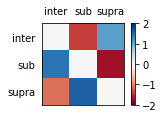

In [65]:
m.plot_norm_diff()

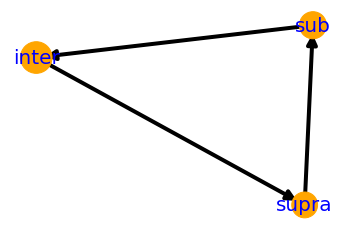

In [66]:
m.plot_graph()

## From `Striplog()` instance

In [67]:
from welly import Well
from striplog import Striplog, Component

w = Well.from_las("P-129_out.LAS")
gr = w.data['GR']

comps = [Component({'lithology': 'sandstone'}),
         Component({'lithology': 'greywacke'}),
         Component({'lithology': 'shale'}),
        ]

s = Striplog.from_log(gr, cutoff=[30, 90], components=comps, basis=gr.basis)
s

Found nonstandard LAS section: ~Parameter


Striplog(672 Intervals, start=1.0668, stop=1939.1376000000012)

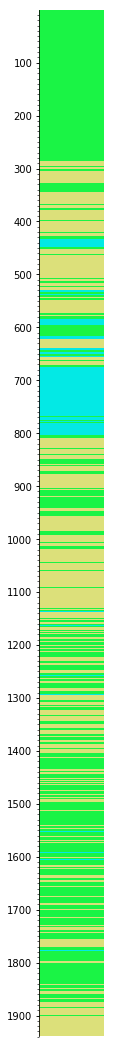

In [68]:
s.plot()

In [69]:
log, z, comps = s.to_log(return_meta=True)
log

array([1, 1, 1, ..., 2, 2, 2])

This is not quite what we want, because it's regularly sampled.

We want the beds only.

In [70]:
s[0]

Interval({'top': Position({'middle': 1.0668, 'units': 'm'}), 'base': Position({'middle': 136.85520000000008, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'greywacke'})]})

In [71]:
seq = [i.primary.lithology for i in s]

In [72]:
m = Markov_chain.from_sequence(seq, strings_are_states=True, include_self=False)

In [73]:
m.normalized_difference

array([[ 0.   ,  0.085,  0.023],
       [ 0.121,  0.   , -0.926],
       [-0.008, -0.928,  0.   ]])

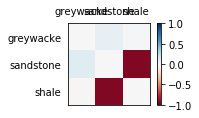

In [74]:
m.plot_norm_diff()

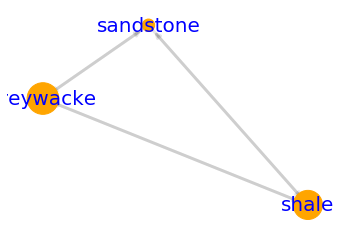

In [75]:
m.plot_graph()

## Using striplog's implementation

In [76]:
import striplog

striplog.__version__

'0.8.3'

In [77]:
from striplog.markov import Markov_chain

In [78]:
m = Markov_chain.from_sequence(seq, strings_are_states=True, include_self=False)

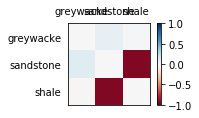

In [79]:
m.plot_norm_diff()

----

&copy; Agile Scientific 2019, licensed CC-BY / Apache 2.0, please share this work